# Install environment

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from mlxtend.frequent_patterns import association_rules, apriori # for mining frequent itemsets and association rule

import warnings
warnings.filterwarnings("ignore")


# Data pre-processing

In [2]:
# load data and get overview
df = pd.read_csv("bread basket.csv")
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


There is no missing value. 

In [4]:
# counting the number of unique transactions
print('The total number of unique transactions is ', df['Transaction'].nunique())

The total number of unique transactions is  9465


In [5]:
# counting the number of selling items
print('The total number of selling items is ', df['Item'].nunique())

The total number of selling items is  94


In [6]:
# convert date_time column into the right format for easier extracting
df['date_time'] = pd.to_datetime(df['date_time'])
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,2016-10-30 09:58:00,morning,weekend
1,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
2,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
3,3,Hot chocolate,2016-10-30 10:07:00,morning,weekend
4,3,Jam,2016-10-30 10:07:00,morning,weekend


In [7]:
# extracting date
df['date'] = df['date_time'].dt.date

# extracting hour
df['hour'] = df['date_time'].dt.hour

# extracting month and display full name of the month
df['month'] = df['date_time'].dt.strftime('%Y-%m')

# extracting weekday and display full name of the weekday
df['weekday'] = df['date_time'].dt.strftime('%A')

# dropping date_time column as it's not necessary anymore
df.drop('date_time', axis = 1, inplace = True)

df.head()

,Transaction,Item,period_day,weekday_weekend,date,hour,month,weekday
0,1,Bread,morning,weekend,2016-10-30,9,2016-10,Sunday
1,2,Scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
2,2,Scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
3,3,Hot chocolate,morning,weekend,2016-10-30,10,2016-10,Sunday
4,3,Jam,morning,weekend,2016-10-30,10,2016-10,Sunday


In [8]:
# change the item name to lowercase and remove any spaces
df['Item'] = df['Item'].str.strip()
df['Item'] = df['Item'].str.lower()
df.head()

,Transaction,Item,period_day,weekday_weekend,date,hour,month,weekday
0,1,bread,morning,weekend,2016-10-30,9,2016-10,Sunday
1,2,scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
2,2,scandinavian,morning,weekend,2016-10-30,10,2016-10,Sunday
3,3,hot chocolate,morning,weekend,2016-10-30,10,2016-10,Sunday
4,3,jam,morning,weekend,2016-10-30,10,2016-10,Sunday


## Data Exploration and Visualizations

### Best selling items

In [9]:
# count the number of items sold in descending order, take Top 20 best selling items
top_items = pd.DataFrame(df['Item'].value_counts(dropna=True, sort=True)).reset_index()
top_items.columns = ['item', 'count']
top_items['percentage'] = top_items['count'].apply(lambda x: x/top_items['count'].sum())
top_items = top_items.head(20)
top_items.head()

,item,count,percentage
0,coffee,5471,0.266787
1,bread,3325,0.162140
2,tea,1435,0.069976
3,cake,1025,0.049983
4,pastry,856,0.041742


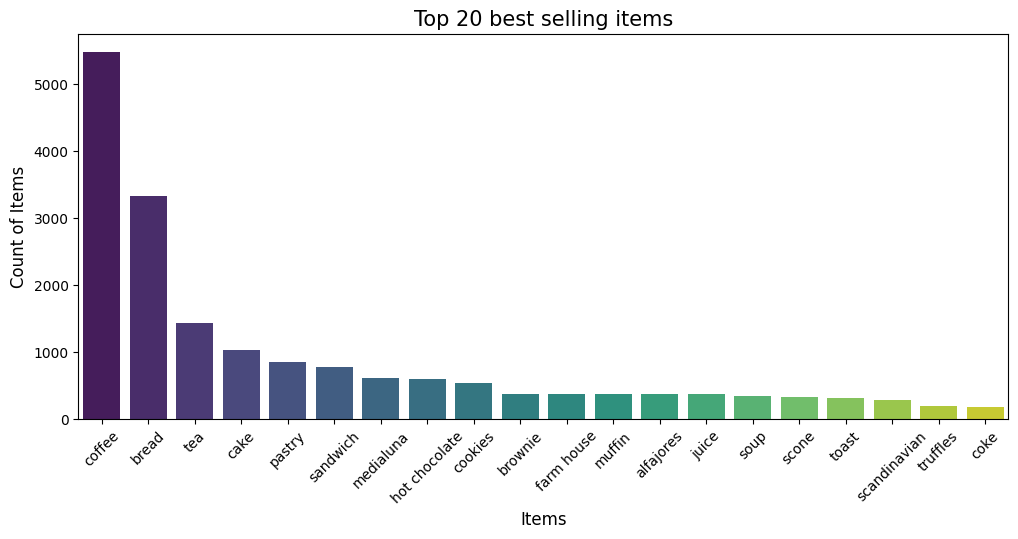

In [10]:
# create bar plot showing Top 20 best selling items
plt.figure(figsize=(12,5))
sns.barplot(x = 'item', y = 'count', data = top_items, palette = 'viridis')
plt.xlabel('Items', size = 12)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 12)
plt.title('Top 20 best selling items', size = 15)
plt.show()

### Number of items per transaction

In [32]:
# create summary table of number of transactions by their number of items
# count the number of items of each transaction
items_num = df.groupby('Transaction', as_index=False)['Item'].count()
# pivot table to display the distribution of transactions by the number of items
items_num = items_num.pivot_table(index='Item', values='Transaction', aggfunc='count')
# calculate percentage
items_num['percentage'] = items_num['Transaction'].apply(lambda x: x/items_num['Transaction'].sum())
items_num

,Transaction,percentage
Item,,
1,3631,0.383624
2,2908,0.307237
3,1528,0.161437
4,850,0.089805
5,341,0.036027
6,135,0.014263
7,38,0.004015
8,21,0.002219
9,7,0.000740


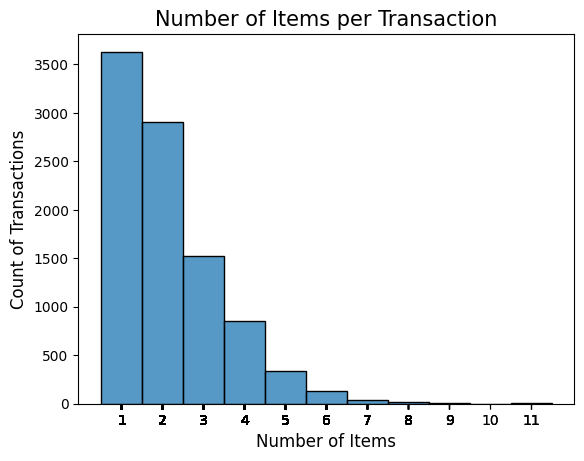

In [11]:
# create histogram plot showing the distribution of transactions by the number of items per transaction
ax = sns.histplot(data= items_num, x = 'Item', discrete=True)
plt.xlabel('Number of Items', size = 12)
ax.set(xticks=items_num['Item'].values)
plt.ylabel('Count of Transactions', size = 12)
plt.title('Number of Items per Transaction', size = 15)
plt.show()

### Quantity Sold by Month

In [35]:
# count the quantity of items sold by month and year
qty_month = df.groupby('month', as_index=False)['Transaction'].count()
qty_month.head()

,month,Transaction
0,2016-01,233
1,2016-02,268
2,2016-03,380
3,2016-04,308
4,2016-05,392


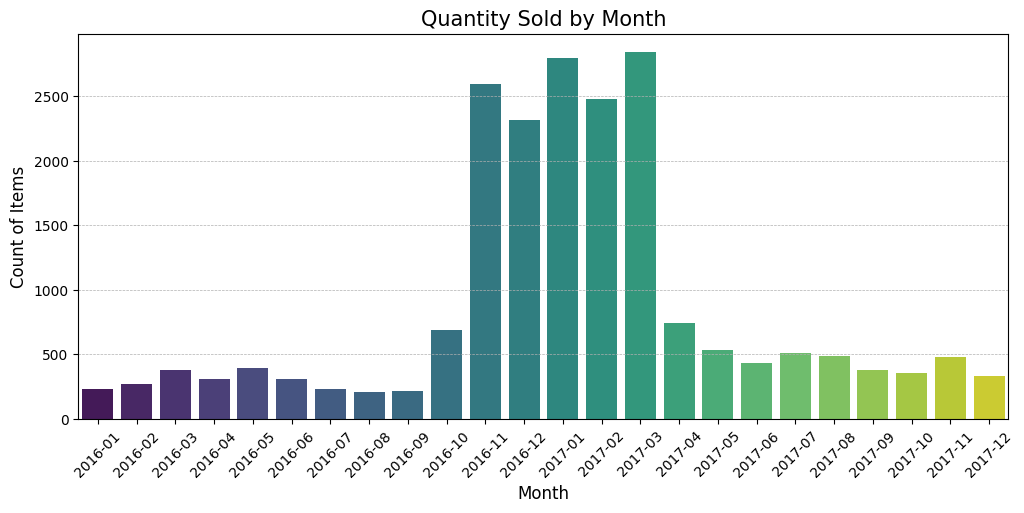

In [36]:
# create bar plot showing the number of items sold by month
plt.figure(figsize=(12,5))
sns.barplot(x = 'month', y = 'Transaction', data = qty_month, palette = 'viridis')
plt.xlabel('Month', size = 12)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 12)
plt.title('Quantity Sold by Month', size = 15)
plt.grid(axis = 'y', ls='--', lw='0.5')
plt.show()

Note that data is recorded from 2016-01-11 to 2017-12-03, so that the value of 2016-01 bar contains items sold of 20 days, 2017-12 bar contains items sold for 3 days only.

### Quantity Sold by Days of Week

In [39]:
# count the number of transactions by days of week, reorder by names of the days
qty_wd = df.groupby('weekday', as_index=False)['Transaction'].count()
qty_wd['wdkey'] = [4,0,5,6,3,1,2]
qty_wd.sort_values("wdkey",inplace=True)
qty_wd

,weekday,Transaction,wdkey
1,Monday,3035,0
5,Tuesday,2645,1
6,Wednesday,2288,2
4,Thursday,2601,3
0,Friday,3266,4
2,Saturday,3554,5
3,Sunday,3118,6


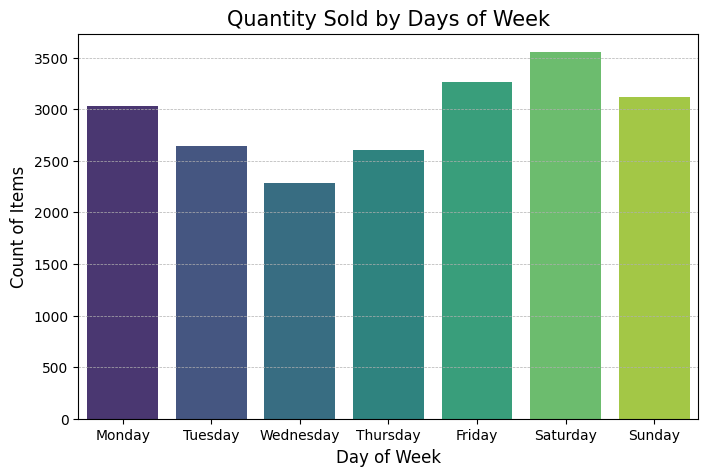

In [40]:
# create bar plot showing the number of items sold by days of week
plt.figure(figsize=(8,5))
sns.barplot(x = 'weekday', y = 'Transaction', data = qty_wd, palette = 'viridis')
plt.xlabel('Day of Week', size = 12)
plt.ylabel('Count of Items', size = 12)
plt.title('Quantity Sold by Days of Week', size = 15)
plt.grid(axis = 'y', ls='--', lw='0.5')
plt.show()

### Quantity Sold by Hours

In [45]:
# count the number of items sold in different hours of a day
# create hour bins to show time period
qty_hr = df.groupby('hour', as_index=False)['Transaction'].count()
qty_hr['hour_bins'] = pd.cut(x=trans_hr.hour, bins = range(0,24,1))
qty_hr.head()

,hour,Transaction,hour_bins
0,1,1,"(0, 1]"
1,7,24,"(6, 7]"
2,8,645,"(7, 8]"
3,9,1966,"(8, 9]"
4,10,2666,"(9, 10]"


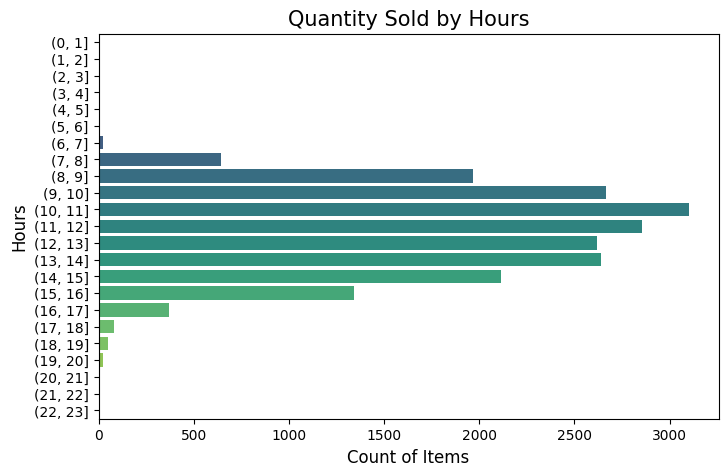

In [43]:
# visualize the distribution of items sold quantity by hours
plt.figure(figsize=(8,5))
sns.barplot(x = 'Transaction', y = 'hour_bins', data = qty_hr, palette = 'viridis')
plt.xlabel('Count of Items', size = 12)
plt.ylabel('Hours', size = 12)
plt.title('Quantity Sold by Hours', size = 15)
plt.show()

# Apply Apriori Algorithm to implement Market Basket Analysis

In [18]:
# select only required variables for modelling
transactions = df.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name ='Count')
transactions.head()

,Transaction,Item,Count
0,1,bread,1
1,2,scandinavian,2
2,3,cookies,1
3,3,hot chocolate,1
4,3,jam,1


The `apriori` function expects input data in a one-hot encoded pandas DataFrame, therefore, we need to transform the dataframe above into the representation of categorical variables as binary vectors.

In [19]:
# first create a mxn matrice where m=transaction and n=items
# each row represents whether the items was in a specific transaction or not (>=1 returns True (1), 0 returns 0)
my_basket = transactions.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='any').fillna(0)

my_basket.head()

Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Minimum support is the minimum frequency or occurrence threshold that an itemset must meet to be considered frequent. 

Let's say an itemset is considered frequent if it appears at least 1% in total number of transactions (1% of 9465). 

In [20]:
# create frequent items df with itemsets and support columns by using `apriori` function
frequent_items = apriori(my_basket, min_support = 0.01, use_colnames = True)
frequent_items

,support,itemsets
0,0.036344,(alfajores)
1,0.016059,(baguette)
2,0.327205,(bread)
3,0.040042,(brownie)
4,0.103856,(cake)
...,...,...
56,0.023666,"(coffee, toast)"
57,0.014369,"(sandwich, tea)"
58,0.010037,"(coffee, bread, cake)"
59,0.011199,"(coffee, bread, pastry)"


Just because an item or itemset is common does not mean that there is a strong association between them. For example, the item "coffee" may have a high support value, but that does not mean there is a strong association between coffee and any other particular item. Therefore, we should consider lift metric when assessing the associations between items.

Lift indicates how many more times A and B actually appear in the same order, compared to if there was no relationship between them. In other words, it takes into account the support of each item to measure the strength of the association between them. A lift value of 1 means that there is no association between the two items. A lift value greater than 1 means that the two items are positively associated, meaning that the presence of one item increases the likelihood of the presence of the other item.

This project will set the minimum threshold for lift metric to 1.2 to return the association rules that occur at least 20% more often than we would expect if they were random.

In [47]:
# create the rules from frequent itemset generated above with min lift = 1.2
rules = association_rules(frequent_items, metric = "lift", min_threshold = 1.2)
rules.sort_values('confidence', ascending = False, inplace = True)
rules.reset_index(drop=True, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(toast),(coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
1,(spanish brunch),(coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
2,(cake),(tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865,0.420538
3,"(coffee, tea)",(cake),0.049868,0.103856,0.010037,0.201271,1.937977,0.004858,1.121962,0.509401
4,(sandwich),(tea),0.071844,0.142631,0.014369,0.200000,1.402222,0.004122,1.071712,0.309050
5,(hot chocolate),(cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125,0.498236
6,"(coffee, cake)",(tea),0.054728,0.142631,0.010037,0.183398,1.285822,0.002231,1.049923,0.235157
7,(tea),(cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372,0.439556
8,(pastry),"(coffee, bread)",0.086107,0.090016,0.011199,0.130061,1.444872,0.003448,1.046033,0.336907
9,"(coffee, bread)",(pastry),0.090016,0.086107,0.011199,0.124413,1.444872,0.003448,1.043749,0.338354


### Parallel coordinates plot

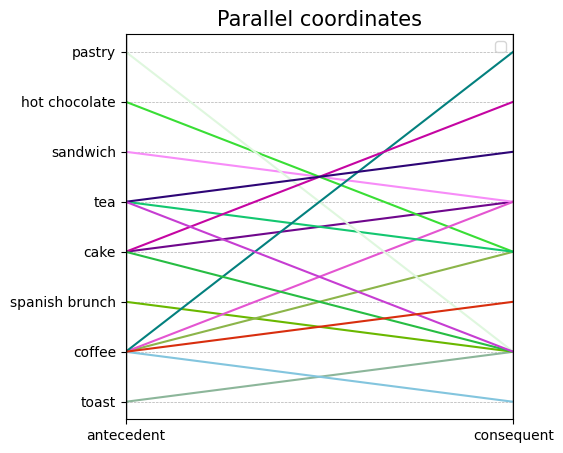

In [22]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

# import sub lib to plot parallel coordinates
from pandas.plotting import parallel_coordinates

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(5,5))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(ls='--', lw='0.5')
plt.title('Parallel coordinates', size = 15)
plt.show()

### Itemsets Lift Heatmap

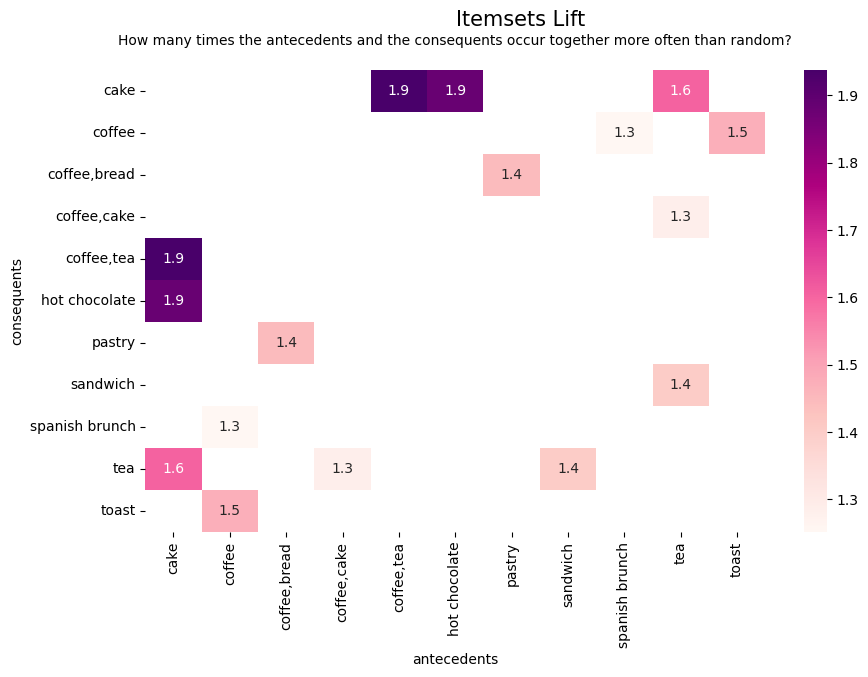

In [23]:
# convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# transform antecedent, consequent, and support columns into matrix
support_table_lift = rules.pivot(index='consequents', columns='antecedents', values='lift')

# generate a heatmap with annotations 
plt.figure(figsize=(10,6))
sns.heatmap(support_table_lift, annot = True, cbar = True, cmap="RdPu")
plt.suptitle('Itemsets Lift', size = 15)
plt.title('How many times the antecedents and the consequents occur together more often than random?\n', size=10)
plt.show()

### Itemsets Confidence Heatmap

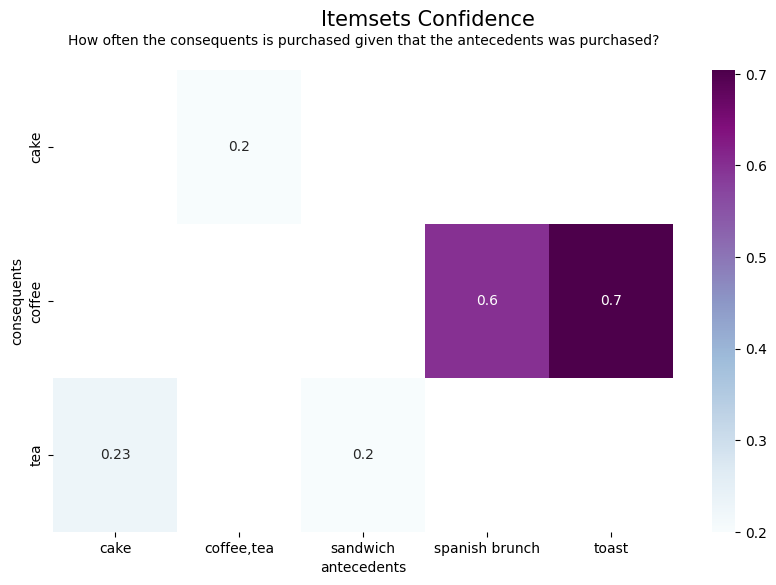

In [24]:
# transform antecedent, consequent, and support columns into matrix
rules_confidence = rules[rules['confidence']>=0.2] # select min lift=1.2
support_table_conf = rules_confidence.pivot(index='consequents', columns='antecedents', values='confidence')

# generate a heatmap with annotations
plt.figure(figsize=(10,6))
sns.heatmap(support_table_conf, annot = True, cbar = True, cmap="BuPu")
plt.suptitle('Itemsets Confidence', size = 15)
plt.title('How often the consequents is purchased given that the antecedents was purchased?\n', size = 10)
plt.show()